In [ ]:
'''
Author: Kazeem Oladejo
Last updated: 07-Mar-2023
Description: Hierarchical Clustering for Computational Grounded Theory experiments
Credit: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
'''

### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline
np.set_printoptions(precision=3, suppress=True) # suppress scientific float notation

### Load data

In [2]:
data = pd.read_csv('<data file>.csv', encoding = "ISO-8859-1")

In [3]:
#corpus = data['smrHashtags'] + data['smrMentions'] + data['smrNER'] # looks poor, centered mass 
#corpus = data['smrHashtags'] + data['smrNouns'] # looks poor, centered mass 
#corpus = data['smrHashtags'] + data['smrMentions'] + data['smrNouns'] # looks poor, centered mass 
#corpus = data['smrHashtags'] + data['smrNouns'] + data['smrVerbs'] # looks poor, centered mass 
#corpus = data['smrNouns'] + data['smrAdverbs'] # looks poor but with a little less center mass
#corpus = data['smrMentions'] + data['smrNouns'] + data['smrAdverbs'] # looks poor but with a little less center mass
#corpus = data['smrMentions'] + data['smrNouns'] + data['smrVerbs'] # looks ok but widely distributed
corpus = data['smrMentions'] + data['smrNouns'] # looks ok but widely distributed
corpus = corpus.fillna(value='')
vec = TfidfVectorizer(min_df=2, ngram_range=(1, 2), max_features=5000)
data_vec = vec.fit_transform(corpus)
data_X = pd.DataFrame(data_vec.toarray(), columns=vec.get_feature_names())
data_X.index = data['RecID']

In [4]:
# Generate TSNE 2D data
reducer = TSNE()
X_2D = reducer.fit_transform(data_X)
df = pd.DataFrame(data=X_2D, columns=["xcoord","ycoord"])
df['RecID'] = data['RecID']
X = df[['xcoord','ycoord']].to_numpy()
X.shape

(1512, 2)

### Perform the Hierarchical Clustering

In [5]:
Z = linkage(X, 'ward')
#Z = linkage(X, 'average', 'cityblock')
Z.shape

(1511, 4)

In [6]:
Z[:30]

array([[1217.   , 1218.   ,    0.002,    2.   ],
       [  91.   ,  716.   ,    0.003,    2.   ],
       [ 581.   , 1322.   ,    0.004,    2.   ],
       [  62.   ,   99.   ,    0.005,    2.   ],
       [   3.   ,    9.   ,    0.006,    2.   ],
       [ 114.   ,  119.   ,    0.006,    2.   ],
       [1087.   , 1111.   ,    0.007,    2.   ],
       [ 243.   , 1164.   ,    0.008,    2.   ],
       [ 128.   ,  135.   ,    0.009,    2.   ],
       [ 604.   ,  607.   ,    0.009,    2.   ],
       [ 218.   ,  283.   ,    0.009,    2.   ],
       [1427.   , 1428.   ,    0.011,    2.   ],
       [ 467.   ,  468.   ,    0.011,    2.   ],
       [ 457.   ,  459.   ,    0.012,    2.   ],
       [ 571.   ,  574.   ,    0.013,    2.   ],
       [ 590.   ,  600.   ,    0.013,    2.   ],
       [ 431.   , 1067.   ,    0.013,    2.   ],
       [ 120.   ,  129.   ,    0.018,    2.   ],
       [ 650.   ,  651.   ,    0.019,    2.   ],
       [ 816.   ,  908.   ,    0.021,    2.   ],
       [ 150.   ,  1

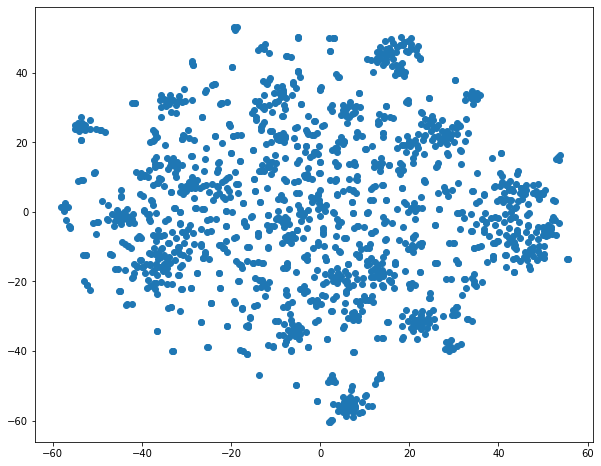

In [7]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1])  # plot all points
plt.show()

### Cophenetic Correlation Coefficient

Check the Cophenetic Correlation Coefficient of the clustering to compares (correlate) the actual pairwise distances of all the samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserved the original distances.

In [8]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.6034336816992761

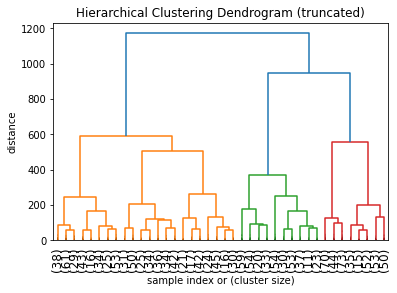

In [9]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=40,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

### Cutting the Dendrogram

AKA Determining the Number of Clusters. A huge jump in distance is typically what we're interested in if we want to argue for a certain number of clusters. Best to inspect this manually, as it allows one to gain some insights into the data and to perform some sanity checks on the edge cases.

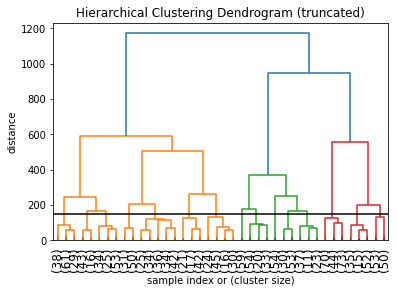

In [10]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=40,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(y=150, c='k') # draw a line at 250 distance or 5 clusters
plt.show()

NOTE: On the x axis of the dendrogram, labels in () indicate a count of the samples in a merged node, but the labels without () are single data points i.e. index of point, unmerged.

### Retrieving the Clusters

In [11]:
from scipy.cluster.hierarchy import fcluster
max_d = 15 # based on the visual inspection of the distance axis
d_clusters = fcluster(Z, max_d, criterion='distance')
d_clusters

array([ 62,  42, 131, ...,  70, 108,  36], dtype=int32)

In [26]:
#from scipy.cluster.hierarchy import fcluster
#max_d = 15 # based on the visual inspection of the distance axis
#clusters = fcluster(Z, max_d, criterion='maxclust')
#clusters

array([4, 5, 3, ..., 2, 4, 3], dtype=int32)

### Visualizing the Clusters

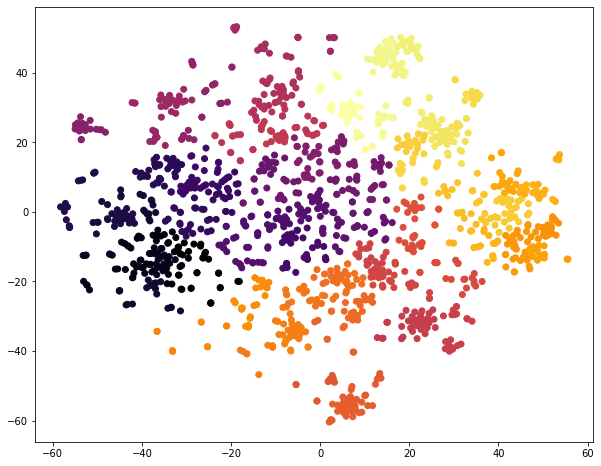

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], c=d_clusters, cmap='inferno')
plt.show()

In [13]:
df['ClusterID'] = pd.DataFrame(d_clusters)

In [14]:
df.head()

,xcoord,ycoord,RecID,ClusterID
0,-12.890456,37.618324,1057291398880391170,62
1,3.540796,9.431225,1124056098925944832,42
2,2.133917,29.823191,1135851552495865857,131
3,14.862166,3.401197,1151389038781390848,44
4,-1.342769,17.116728,1165822705037217792,48


In [15]:
df.to_csv('GrdTr_doc_cluster_vs.csv')

In [16]:
df.groupby(by='ClusterID').count()

,xcoord,ycoord,RecID
ClusterID,,,
1,17,17,17
2,12,12,12
3,9,9,9
4,11,11,11
5,9,9,9
...,...,...,...
127,25,25,25
128,10,10,10
129,10,10,10


### Get a list of ClusterIDs

In [17]:
clust_ndarray = df.ClusterID.unique()
clust_list =sorted(clust_ndarray)

## Select Random 20% of Doc_Cluster

In [116]:
df_doc_cluster_random = pd.DataFrame(columns=['xcoord', 'ycoord','RecID','ClusterID'])
i=0
for i in range(len(clust_list)+1):
    df_temp = df[(df.ClusterID == i)]
    if len(df_temp) > 19: # discard clusters with less than 20 members
        df_temp = df_temp.sample(frac= 0.2, weights='ClusterID', random_state=1)
        df_doc_cluster_random = pd.concat([df_doc_cluster_random, df_temp])

In [117]:
df_doc_cluster_random

,xcoord,ycoord,RecID,ClusterID
696,-22.564224,-19.456455,1197900177098596353,1
1110,-26.810030,-28.118929,1214302920390402050,1
1,3.060320,-36.732246,1124056098925944832,1
425,-16.201519,-47.178211,1189771617653661696,1
223,-23.260075,-24.476789,1183890116844183555,1
...,...,...,...,...
142,-7.203379,20.475138,1182050611392585728,14
31,-19.446526,23.052952,1179660469759438849,14
309,-7.279444,15.275769,1186502003280596993,14
1220,-20.923981,26.412802,1216444262453301249,14


In [118]:
len(df)

1512

In [119]:
df_doc_cluster_random.groupby(by='ClusterID').count()

,xcoord,ycoord,RecID
ClusterID,,,
1,23,23,23
2,9,9,9
3,24,24,24
4,26,26,26
5,16,16,16
6,15,15,15
7,24,24,24
8,21,21,21
9,12,12,12


In [120]:
df_doc_cluster_random.to_csv('df_doc_cluster_rand20percent.csv')

## Select top 20% of Doc_Cluster

In [121]:
df_doc_cluster_top20pcent = pd.DataFrame(columns=['xcoord', 'ycoord','RecID','ClusterID'])
i=0
for i in range(len(clust_list)+1):
    df_temp = df[(df.ClusterID == i)]
    if len(df_temp) > 19: # discard clusters with less than 20 members
        df_temp = df_temp.head(int(len(df_temp)/5)) #select top 20%
        df_doc_cluster_top20pcent = pd.concat([df_doc_cluster_top20pcent, df_temp])

In [122]:
df_doc_cluster_top20pcent

,xcoord,ycoord,RecID,ClusterID
1,3.060320,-36.732246,1124056098925944832,1
67,-24.650436,-24.682135,1181047749678161920,1
76,-21.535807,-24.942284,1181191973367160834,1
81,-30.643484,-37.242630,1181208441551015938,1
85,-4.395874,-35.489475,1181214824958701569,1
...,...,...,...,...
309,-7.279444,15.275769,1186502003280596993,14
330,-12.321994,27.440395,1187489783024627715,14
349,-15.829891,30.394247,1188541919485399040,14
376,-0.292062,31.051136,1189175248035483648,14


In [123]:
df_doc_cluster_top20pcent.groupby(by='ClusterID').count()

,xcoord,ycoord,RecID
ClusterID,,,
1,23,23,23
2,9,9,9
3,23,23,23
4,25,25,25
5,16,16,16
6,15,15,15
7,24,24,24
8,20,20,20
9,12,12,12


In [124]:
df_doc_cluster_top20pcent.to_csv('df_doc_cluster_top20pcent.csv')